In [137]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, plot_roc_curve, roc_curve, roc_auc_score

# import seabron as sns
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Data "PreProcessing"

In [87]:
# Get the image file directories
train_dir = os.path.join('/Users/luctheduke/Desktop/UVM Grad School/Year 2/STAT 287 - DS 1/chest_xray/train')
test_dir = os.path.join('/Users/luctheduke/Desktop/UVM Grad School/Year 2/STAT 287 - DS 1/chest_xray/test')
validation_dir = os.path.join('/Users/luctheduke/Desktop/UVM Grad School/Year 2/STAT 287 - DS 1/chest_xray/val')

In [88]:
# Create datasets for training, testing, and validation
IMAGE_SIZE = (300, 300)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, 
                                                                 image_size=IMAGE_SIZE,
                                                                 label_mode='binary', 
                                                                 batch_size=64,
                                                                )

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=64,
                                                                label_mode="binary",shuffle=False)


val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=validation_dir,
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=64,
                                                                label_mode="binary", shuffle=False)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


# EDA
- visualize number breakdown of classes in each of the train, test, and validation sets (see if we have a relatively balanced training set)
- visualize samples of Pneumonia and Normal images

In [89]:
labels = ['NORMAL', 'PNEUMONIA']
train_counts = {}

for l in labels:
    # train counts
    path = os.path.join(train_dir,l)
    fileList=os.listdir(path)
    train_counts[l] = len(fileList)

train_counts

{'NORMAL': 1341, 'PNEUMONIA': 3875}

In [90]:
class_weights = {}
class_weights[0] = (1/train_counts['NORMAL']) * ((train_counts['NORMAL']+train_counts['PNEUMONIA'])/ 2)
class_weights[1] = (1/train_counts['PNEUMONIA']) * ((train_counts['NORMAL']+train_counts['PNEUMONIA'])/ 2)
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

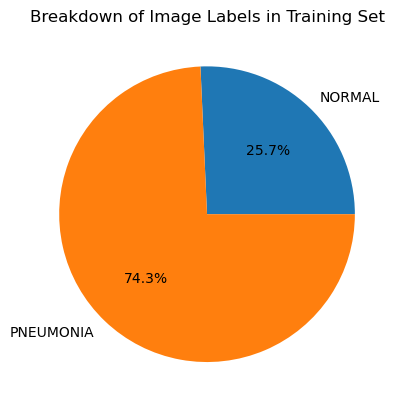

In [91]:
plt.title("Breakdown of Image Labels in Training Set")
plt.pie(list(train_counts.values()), labels=list(train_counts.keys()), autopct='%1.1f%%')
plt.savefig('/Users/luctheduke/Desktop/UVM Grad School/Year 2/STAT 287 - DS 1/stat287_project/images/' + 'pie.png')

The training data is not a balanced set - almost three times as many of the images are labeled to have pneumonia vs normal; this imbalance in the dataset could be problematic for our model.

Consider duplicating Normal dataset 3x to give close to a balanced dataset; consider data augmentation [stretching / rotating / zooming in & out depending on how standard format the images are]

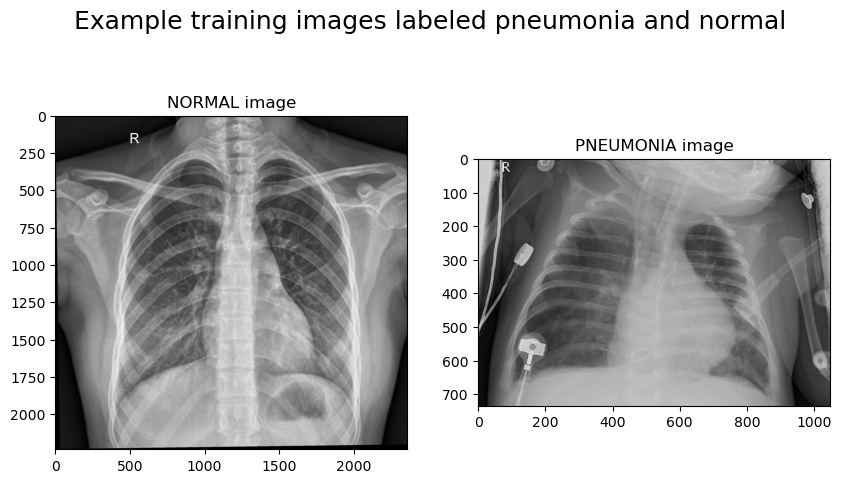

In [92]:
# Plotting code here: representative training images with pneumonia and normal
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
plt.suptitle("Example training images labeled pneumonia and normal", fontsize=18, y=0.95)

for l, ax in zip(labels, axs.ravel()):
    path = os.path.join(train_dir,l)
    for img in os.listdir(path):
        img_arr = Image.open(os.path.join(path,img)) 
        arr = np.array(img_arr)
        ax.set_title(f"{l} image")
        ax.imshow(np.array(img_arr), cmap='gray')
        break

In [93]:
# Preprocess the data
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

# 2. Model Building

In [94]:
# Construct the Model - 4 Conv layers w 2x2 Max Pooling layers after each

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu',
    input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 33, 64)       

In [95]:
# Compiling the model
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["acc", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                       tf.keras.metrics.SpecificityAtSensitivity(0.5), tf.keras.metrics.SensitivityAtSpecificity(0.5)])

In [96]:
# Fit the model
history = model.fit(train_data,
                   epochs=10,
                   steps_per_epoch=len(train_data),
                   class_weight=class_weights
                   )

Epoch 1/10
82/82 [==============================] - 219s 3s/step - loss: 3.8314 - acc: 0.7673 - precision_2: 0.9167 - recall_2: 0.7554 - specificity_at_sensitivity_2: 0.9165 - sensitivity_at_specificity_2: 0.9223
Epoch 2/10
82/82 [==============================] - 200s 2s/step - loss: 0.1767 - acc: 0.9317 - precision_2: 0.9780 - recall_2: 0.9290 - specificity_at_sensitivity_2: 0.9970 - sensitivity_at_specificity_2: 0.9954
Epoch 3/10
82/82 [==============================] - 200s 2s/step - loss: 0.1292 - acc: 0.9503 - precision_2: 0.9837 - recall_2: 0.9489 - specificity_at_sensitivity_2: 0.9993 - sensitivity_at_specificity_2: 0.9964
Epoch 4/10
82/82 [==============================] - 200s 2s/step - loss: 0.1004 - acc: 0.9607 - precision_2: 0.9896 - recall_2: 0.9572 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 0.9997
Epoch 5/10
82/82 [==============================] - 201s 2s/step - loss: 0.0993 - acc: 0.9617 - precision_2: 0.9891 - recall_2: 0.9590 - specificity

# 3. Model Evaluation

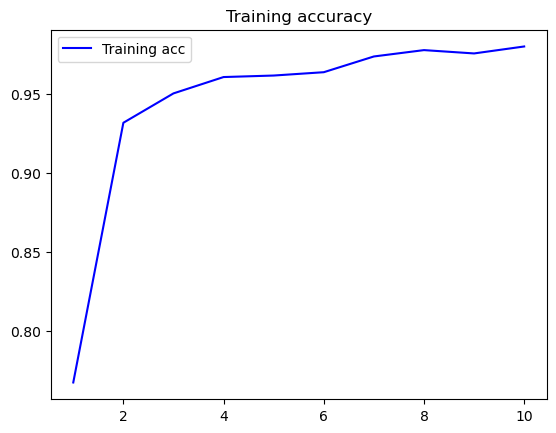

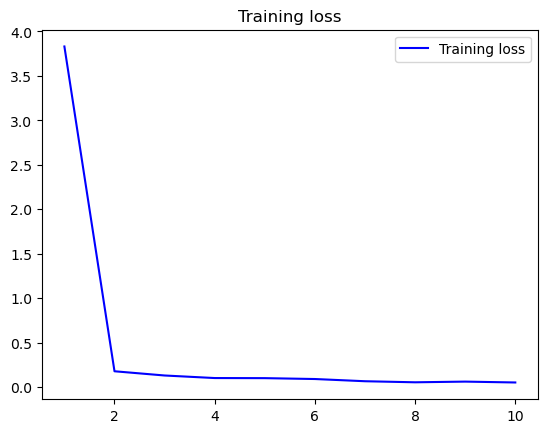

In [99]:
acc = history.history['acc']
# val_acc = history.history['val_acc']
# print(val_acc)
loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'green', label='Validation acc')
# plt.title('Training and validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.savefig('images/cnn_train_acc.png')
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'green', label='Validation loss')
# plt.title('Training and validation loss')
plt.title('Training loss')
plt.savefig('images/cnn_train_loss.png')
plt.legend()

plt.show()

In [100]:
all_metrics = model.evaluate(test_data, steps=10, batch_size=32)

print(all_metrics)

10/10 [==============================] - 8s 646ms/step - loss: 1.3522 - acc: 0.7436 - precision_2: 0.7106 - recall_2: 0.9949 - specificity_at_sensitivity_2: 0.7051 - sensitivity_at_specificity_2: 0.9872
[1.3521922826766968, 0.7435897588729858, 0.7106227278709412, 0.9948717951774597, 0.7051281929016113, 0.9871794581413269]


In [101]:
predictions = (model.predict(test_data) > 0.5).astype("int32")

In [102]:
y_true = np.concatenate([y for x, y in test_data], axis=0)

In [103]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

         0.0       0.97      0.32      0.49       234
         1.0       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624



In [104]:
x_test = np.concatenate([x for x, y in test_data], axis=0)

In [105]:
# Plot confusion matrix - on training data
y_train = np.concatenate([x for x, y in train_data], axis=0)
train_pred = (model.predict(train_data) > 0.5).astype("int32")

res = tf.math.confusion_matrix(y_train.flatten(), train_pred.flatten())
res

KeyboardInterrupt: 

In [108]:
class_names = ['NORMAL', 'PNEUMONIA']

x_test = np.concatenate([x for x, y in test_data], axis=0)
y_test = np.concatenate([y for x, y in test_data], axis=0)

predictions = (model.predict(test_data) > 0.5).astype("int32")

print(classification_report(y_test, predictions))

# Helper function for plotting confusion matrix from tf model
class estimator:
    _estimator_type = ''
    classes_=[]
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_prob= self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)
        return y_pred

              precision    recall  f1-score   support

         0.0       0.97      0.32      0.49       234
         1.0       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624



# PLOT ROC Curve with AUC score

In [148]:
# Extract training dataset
x_train = np.concatenate([x for x, y in train_data], axis=0)
y_train = np.concatenate([y for x, y in train_data], axis=0)

# Get ROC for training dataset
fpr_train, tpr_train, _train = roc_curve(y_train, model.predict(x_train))
roc_auc_train = roc_auc_score(y_train, model.predict(x_train))

In [151]:
fpr_train, tpr_train

(array([0.        , 0.11558538, 0.12453393, ..., 0.99925429, 1.        ,
        1.        ]),
 array([0.        , 0.11690323, 0.12335484, ..., 0.99870968, 0.99870968,
        1.        ]))

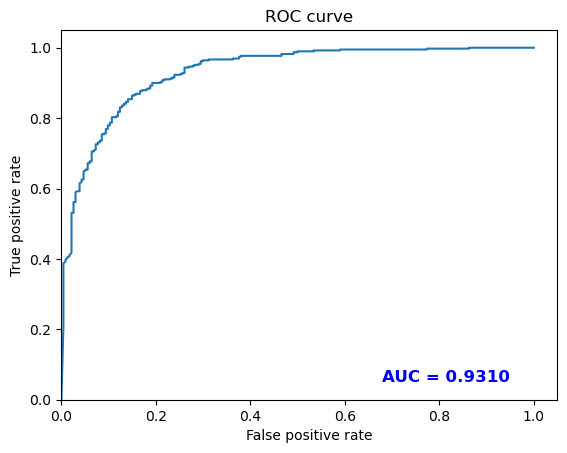

In [152]:
fpr, tpr, _ = roc_curve(y_test, model.predict(x_test))
roc_auc = roc_auc_score(y_test, model.predict(x_test))

plt.plot(fpr, tpr, label='test ROC')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.text(0.95, 0.05, 'AUC = %0.4f' % roc_auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.savefig('images/cnn_ROC.png')

In [136]:
import seaborn as sns

In [163]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
  plt.title('Confusion matrix at {:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.savefig('images/cnn_conf_mat.png')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Legitimate Transactions Detected (True Negatives):  76
Legitimate Transactions Incorrectly Detected (False Positives):  158
Fraudulent Transactions Missed (False Negatives):  2
Fraudulent Transactions Detected (True Positives):  388
Total Fraudulent Transactions:  390


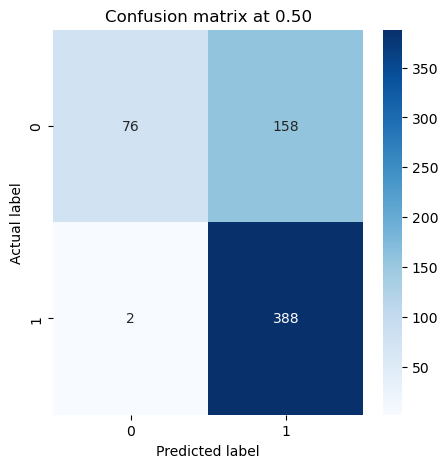

In [164]:
plot_cm(y_test.ravel(), model.predict(x_test).ravel())

In [139]:
baseline_results = model.evaluate(x_test, y_test, verbose=0)

In [140]:
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  1.3521924018859863
acc :  0.7435897588729858
precision_2 :  0.7106227278709412
recall_2 :  0.9948717951774597
specificity_at_sensitivity_2 :  0.7051281929016113
sensitivity_at_specificity_2 :  0.9871794581413269



# 4. Model Interpretation - LIME (Local Interpretable Model-Agnostic Explanations)

resources:
1. https://homes.cs.washington.edu/~marcotcr/blog/lime/
2. https://medium.datadriveninvestor.com/xai-with-lime-for-cnn-models-5560a486578
3. https://stackoverflow.com/questions/62436302/extract-target-from-tensorflow-prefetchdataset#_=_

In [16]:
# !pip3 install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

In [26]:
training_sample = [(example.numpy(), label.numpy()) for example, label in train_data][10]

(array([[[[3.33507767e+01, 3.33507767e+01, 3.33507767e+01],
          [3.36556664e+01, 3.36556664e+01, 3.36556664e+01],
          [3.51138878e+01, 3.51138878e+01, 3.51138878e+01],
          ...,
          [4.44533348e+01, 4.44533348e+01, 4.44533348e+01],
          [3.78499756e+01, 3.78499756e+01, 3.78499756e+01],
          [3.44792175e+01, 3.44792175e+01, 3.44792175e+01]],
 
         [[3.21800003e+01, 3.21800003e+01, 3.21800003e+01],
          [3.23300018e+01, 3.23300018e+01, 3.23300018e+01],
          [3.51049995e+01, 3.51049995e+01, 3.51049995e+01],
          ...,
          [4.70698776e+01, 4.70698776e+01, 4.70698776e+01],
          [3.80299759e+01, 3.80299759e+01, 3.80299759e+01],
          [3.32833252e+01, 3.32833252e+01, 3.32833252e+01]],
 
         [[3.23666687e+01, 3.23666687e+01, 3.23666687e+01],
          [3.25166702e+01, 3.25166702e+01, 3.25166702e+01],
          [3.55833359e+01, 3.55833359e+01, 3.55833359e+01],
          ...,
          [4.52498779e+01, 4.52498779e+01, 4.5249

In [27]:
training_sample

(array([[[[3.33507767e+01, 3.33507767e+01, 3.33507767e+01],
          [3.36556664e+01, 3.36556664e+01, 3.36556664e+01],
          [3.51138878e+01, 3.51138878e+01, 3.51138878e+01],
          ...,
          [4.44533348e+01, 4.44533348e+01, 4.44533348e+01],
          [3.78499756e+01, 3.78499756e+01, 3.78499756e+01],
          [3.44792175e+01, 3.44792175e+01, 3.44792175e+01]],
 
         [[3.21800003e+01, 3.21800003e+01, 3.21800003e+01],
          [3.23300018e+01, 3.23300018e+01, 3.23300018e+01],
          [3.51049995e+01, 3.51049995e+01, 3.51049995e+01],
          ...,
          [4.70698776e+01, 4.70698776e+01, 4.70698776e+01],
          [3.80299759e+01, 3.80299759e+01, 3.80299759e+01],
          [3.32833252e+01, 3.32833252e+01, 3.32833252e+01]],
 
         [[3.23666687e+01, 3.23666687e+01, 3.23666687e+01],
          [3.25166702e+01, 3.25166702e+01, 3.25166702e+01],
          [3.55833359e+01, 3.55833359e+01, 3.55833359e+01],
          ...,
          [4.52498779e+01, 4.52498779e+01, 4.5249

In [25]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         training_sample, 
         model.predict
)
plt.imshow(training_sample)

image, mask = explanation.get_image_and_mask(
         model.predict(
              training_sample.reshape((1,28,28,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

AttributeError: 'tuple' object has no attribute 'shape'